⚡ In this project, I built a couple of UNet-based models for the task of Multiclass Semantic Segmentation of satellite images of Dubai to compare their performance.

I built 5 models including the classic UNet and Vision-Transformer-based UNet (UNETR).
The other 3 models are variations of it (VGG10-UNet, Densenet-121-Unet, Attention-UNet)

In conclusion, using 2088 images to train models, Densenet-121-Unet achieved the best performance with an accuracy of 89% compared to others. 

In [4]:
# Import libraries
import os
import cv2
import IPython
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model , load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
# The dataset consists of 72 aerial images of Dubai & annotated with pixel-wise semantic segmentation in 6 classes.
# https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
root_folder = './SemanticSegmentationDataset'

In [6]:
# Image config
img_size = 256
num_channels = 3
input_shape = (img_size, img_size, num_channels)

# Transformers encoder hyperparameters config
patch_size = 16
num_patches = (img_size // patch_size) * (img_size // patch_size)
mlp_dim = 3072  # dimensionality of the hidden layers in the Multi-Layer Perceptron (MLP) component of the mode
num_heads = 12  # Number of attention heads in the multi-head attention layer
hidden_dim = 768 # the size of the feature vectors (embeddings) for representing the input data
dropout_rate= 0.2
transformer_layers = 12 # Number of transformer blocks
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

# MinMaxScaler for rescaling each variable to a range of 0-1
scaler = MinMaxScaler()

In [7]:
# Raw input images are of various sizes, thus we should capture all images into numpy arrays,
# then crop them into the nearest size which is divisible by 256 (img_size), following this cut them into a fixed-size and extract 256X256 patches.
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):

    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]

    if dir_name== 'images':
        print('-----------------------------------------------\n', 'Image Directory Path: ', path)

        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()

        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'):
                print('-------------------\n', img)

                #read images in RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(' image shape: ',image.shape)

                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_size) * img_size
                sizeY = (image.shape[0] // img_size) * img_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))

                # convert images into numpy array
                image = np.array(image)

                # cut up images into non-overlapped 256x256 pieces
                patched_imgs = patchify(image , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ',patched_imgs.shape)

                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]

                        # add all patches to a list
                        img_dataset.append(single_patch_img)

-----------------------------------------------
 Image Directory Path:  ./SemanticSegmentationDataset/Tile 3/images
-------------------
 image_part_001.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_008.jpg
 image shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------


In [8]:
msk_dataset = []

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]

    if dirname == 'masks':
        print('-----------------------------------------------\n', 'Mask Directory Path: ', path)

        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()


        for i, msk in enumerate(masks_lst):
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)

                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(' mask shape: ', mask.shape)

                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_size)*img_size
                sizeY = (mask.shape[0]//img_size)*img_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY))

                # convert masks into numpy array
                mask = np.array(mask)

                # cut up masks into 256x256 pieces for data augmentation
                patched_masks = patchify(mask , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ', patched_masks.shape)

                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):

                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]

                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask)

-----------------------------------------------
 Mask Directory Path:  ./SemanticSegmentationDataset/Tile 3/masks
-------------------
 image_part_001.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_002.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_003.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_004.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_005.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_006.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_007.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_part_008.png
 mask shape:  (658, 682, 3)
 patche shape:  (2, 2, 1, 256, 256, 3)
-------------------
 image_par

In [9]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

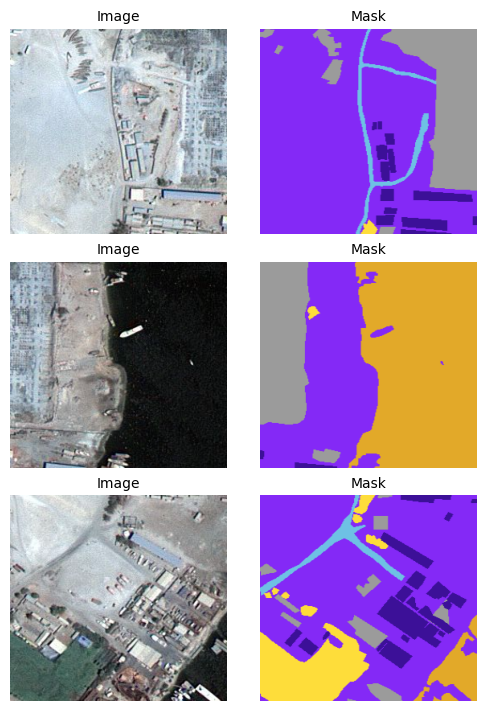

In [10]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(5, 7), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (270,256)))
        axs[count][0].set_title('Image', fontdict = {'fontsize':10})
        axs[count][0].axis(False)

        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (270,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].axis(False)

        count +=1
    i += 1
    if (count==3):
        break

plt.show()

In [11]:
# Mask are RGB and information is provided in HEX color code, so we need to:
# 1) Convert HEX labels to RGB values--------------------------------------------------------------------------
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


# 2) Convert RGB labels to integer values--------------------------------------------------------------------------
def rgb_to_2D_label(msk_dt):
    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)
    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5
    label_seg = label_seg[:,:,0]
    return label_seg

labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
print("-----------------------------")
print(labels.shape)


# 3) one-hot encode labels, since it's a multiclass segmentation task ----------------------------------------------
print("-----------------------------")
print("all labels : ", np.unique(labels))
num_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=num_classes)

Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]
-----------------------------
(1305, 256, 256, 1)
-----------------------------
all labels :  [0 1 2 3 4 5]


In [12]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1044, 256, 256, 3)
y_train shape:  (1044, 256, 256, 6)
X_test shape:  (261, 256, 256, 3)
y_test shape:  (261, 256, 256, 6)


In [13]:
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=0) for x in X_train]
Vy = [np.flip(x, axis=0) for x in y_train]
X_train = np.append(X_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)


In [14]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (2088, 256, 256, 3)
y_train shape:  (2088, 256, 256, 6)
X_test shape:  (261, 256, 256, 3)
y_test shape:  (261, 256, 256, 6)


In [15]:
# cutting up 256X256 images into 16X16 patches for fedding them into the Tranformers encoder
x_train =[]
x_test =[]

for img in X_train:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)  # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_train.append(rs_patches)

for img in X_test:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size) # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_test.append(rs_patches)

x_train = np.array(x_train)
x_test = np.array(x_test)
print('Transformers x_train shape: ', x_train.shape)
print('Transformers x_test shape: ', x_test.shape)

Transformers x_train shape:  (2088, 256, 768)
Transformers x_test shape:  (261, 256, 768)


In [17]:
# UNETR model => Transformer ecoder (as backbone to leran the global contexual representation) & CNN-based decoder (to upsample the global representation and generate the final segmentation mask)
# encoder
def mlp(x, mlp_dim, hidden_dim, dropout_rate):
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def vit_encoder(x, num_heads, hidden_dim):
    # Layer normalization 1
    x1 = layers.LayerNormalization()(x)
    # multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    # Layer normalization 2
    x3 = layers.LayerNormalization()(x2)
    # MLP
    x3 = mlp(x3, mlp_dim, hidden_dim, dropout_rate)
    x = layers.Add()([x3, x2])
    return x

# decoder
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def deconv_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [18]:
def UNETR_2D():
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = layers.Input(input_shape)

    # Patch & Position Embeddings ----------------------------------------------------------------------
    patch_embed = layers.Dense(hidden_dim)(inputs)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    x = patch_embed + positions_embed

    # Transformer Encoder ------------------------------------------------------------------------------
    skip_connection_index = [3, 6, 9, 12] # the number of transformers layers in which there are skip conncetions based on the original paper (z3, z6,z9,z12)
    skip_connections = [] # svae the outputs of transformers layers in which there are skip conncetions

    # 12 layers of the Transformer block
    for i in range(1, transformer_layers+1, 1):
        x = vit_encoder(x, num_heads, hidden_dim)
        if i in skip_connection_index:
            skip_connections.append(x)

    # CNN Decoder ---------------------------------------------------------------------------------------
    z3, z6, z9, z12 = skip_connections

    # reshape the transformers outputs to pass to the CNN decoder (skip connections)
    z0 = layers.Reshape((img_size, img_size, num_channels))(inputs)
    shape = (img_size//patch_size,img_size//patch_size,hidden_dim)
    z3 = layers.Reshape(shape)(z3)
    z6 = layers.Reshape(shape)(z6)
    z9 = layers.Reshape(shape)(z9)
    z12 = layers.Reshape(shape)(z12)

    ## Decoder 1--------------
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2--------------
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3--------------
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4--------------
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = layers.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [19]:
UNETR_model = UNETR_2D()
UNETR_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 768)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             590592    ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 768)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 256, 768)             1536      ['tf.__operators__.add[0][

In [20]:
keras.utils.plot_model(
    UNETR_model,
    to_file='UNETR_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
UNETR_model.compile(optimizer=Adam(lr=0.0001), loss = "categorical_crossentropy" , metrics = ['accuracy'])

UNETR_checkpoint = ModelCheckpoint("./UNETR.weights.h5",monitor='val_loss', verbose=1, save_best_only=True, mode='max')
UNETR_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
UNETR_reduce_learningrate = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
UNETR_callbacks_list = [UNETR_early_stopping,UNETR_checkpoint,UNETR_reduce_learningrate]

In [27]:
history_UNETR = UNETR_model.fit(x_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(x_test, y_test), callbacks = UNETR_callbacks_list, shuffle=True)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.6893
Epoch 1: val_loss improved from -inf to 1.60038, saving model to ./UNETR.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 177s 1s/step - loss: 0.8445 - accuracy: 0.6893 - val_loss: 1.6004 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.8656 - accuracy: 0.6789
Epoch 2: val_loss did not improve from 1.60038


131/131 [==============================] - 116s 883ms/step - loss: 0.8656 - accuracy: 0.6789 - val_loss: 1.0580 - val_accuracy: 0.7077 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6840
Epoch 3: val_loss improved from 1.60038 to 2.41519, saving model to ./UNETR.weights.h5


131/131 [==============================] - 129s 984ms/step - loss: 0.8513 - accuracy: 0.6840 - val_loss: 2.4152 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.6880
Epoch 4: val_loss did not improve from 2.41519


131/131 [==============================] - 116s 882ms/step - loss: 0.8426 - accuracy: 0.6880 - val_loss: 0.7475 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.8390 - accuracy: 0.6868
Epoch 5: val_loss improved from 2.41519 to 2.51439, saving model to ./UNETR.weights.h5


131/131 [==============================] - 128s 976ms/step - loss: 0.8390 - accuracy: 0.6868 - val_loss: 2.5144 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.6718
Epoch 6: val_loss did not improve from 2.51439


131/131 [==============================] - 115s 875ms/step - loss: 0.8925 - accuracy: 0.6718 - val_loss: 1.2620 - val_accuracy: 0.5441 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.6731
Epoch 7: val_loss did not improve from 2.51439


131/131 [==============================] - 115s 874ms/step - loss: 0.8847 - accuracy: 0.6731 - val_loss: 1.0507 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.8665 - accuracy: 0.6805
Epoch 8: val_loss did not improve from 2.51439


131/131 [==============================] - 114s 873ms/step - loss: 0.8665 - accuracy: 0.6805 - val_loss: 1.0325 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.6932
Epoch 9: val_loss did not improve from 2.51439


131/131 [==============================] - 116s 883ms/step - loss: 0.8324 - accuracy: 0.6932 - val_loss: 0.8795 - val_accuracy: 0.6645 - lr: 0.0010


In [28]:
df_UNETR = pd.DataFrame(history_UNETR.history)
df_UNETR

,loss,accuracy,val_loss,val_accuracy,lr
0,0.844475,0.689251,1.600376,0.569645,0.001
1,0.865590,0.678924,1.058024,0.707742,0.001
2,0.851287,0.684022,2.415186,0.316702,0.001
3,0.842650,0.687961,0.747458,0.720976,0.001
4,0.839017,0.686844,2.514389,0.567273,0.001
5,0.892473,0.671755,1.262025,0.544067,0.001
6,0.884679,0.673125,1.050697,0.649107,0.001
7,0.866465,0.680540,1.032527,0.616592,0.001
8,0.832424,0.693192,0.879505,0.664504,0.001


In [29]:
# evalute model
loss_UNETR,acc_UNETR= UNETR_model.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc_UNETR)

9/9 [==============================] - 11s 488ms/step - loss: 0.7475 - accuracy: 0.7210
accuracy: 0.7209751009941101


<Axes: >

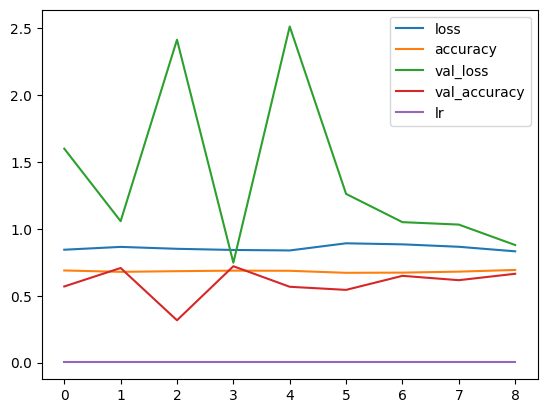

In [30]:
pd.DataFrame(history_UNETR.history).plot()

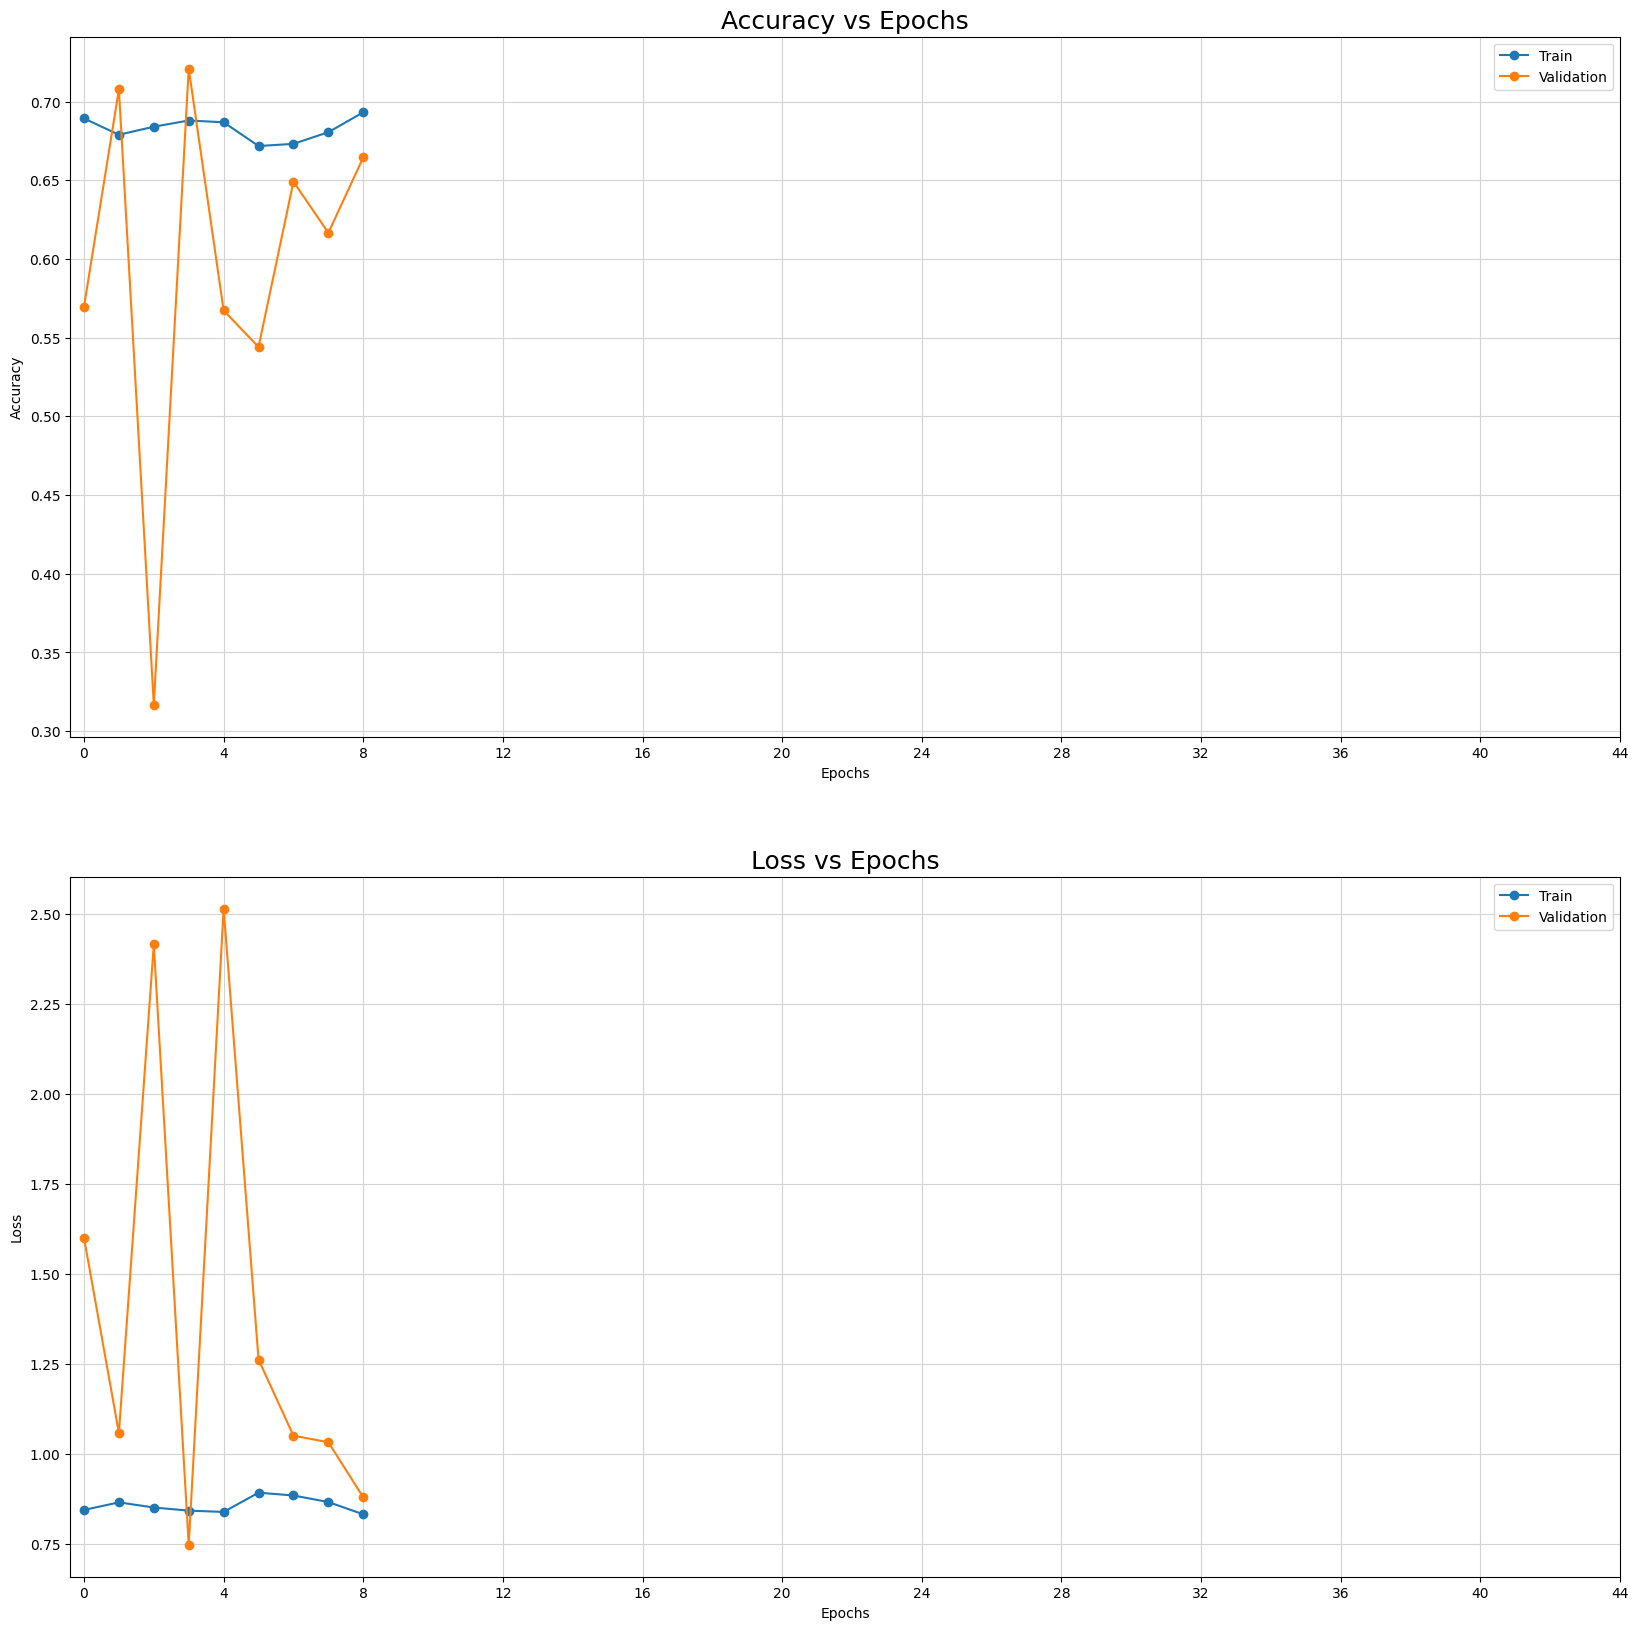

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_UNETR.history[met], 'o-')
    ax[i].plot(history_UNETR.history['val_' + met], 'o-')
    ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [39]:
UNETR_model.save("./drive/MyDrive/Colab Notebooks/Multiclass_segmentation_UNETR_CNN_ViT_Model.h5")

In [16]:
satellite_model_UNETR = load_model('./drive/MyDrive/Colab Notebooks/Multiclass_segmentation_UNETR_CNN_ViT_Model.h5', compile=True, safe_mode=True)

In [17]:
loss_UNETR2,acc_UNETR2= satellite_model_UNETR.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc_UNETR2)

9/9 [==============================] - 56s 4s/step - loss: 0.7475 - accuracy: 0.7210
accuracy: 0.7209736704826355


In [18]:
y_pred_UNETR=satellite_model_UNETR.predict(x_test)

9/9 [==============================] - 30s 3s/step


In [19]:
y_pred_UNETR_argmax=np.argmax(y_pred_UNETR, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 3s 3s/step


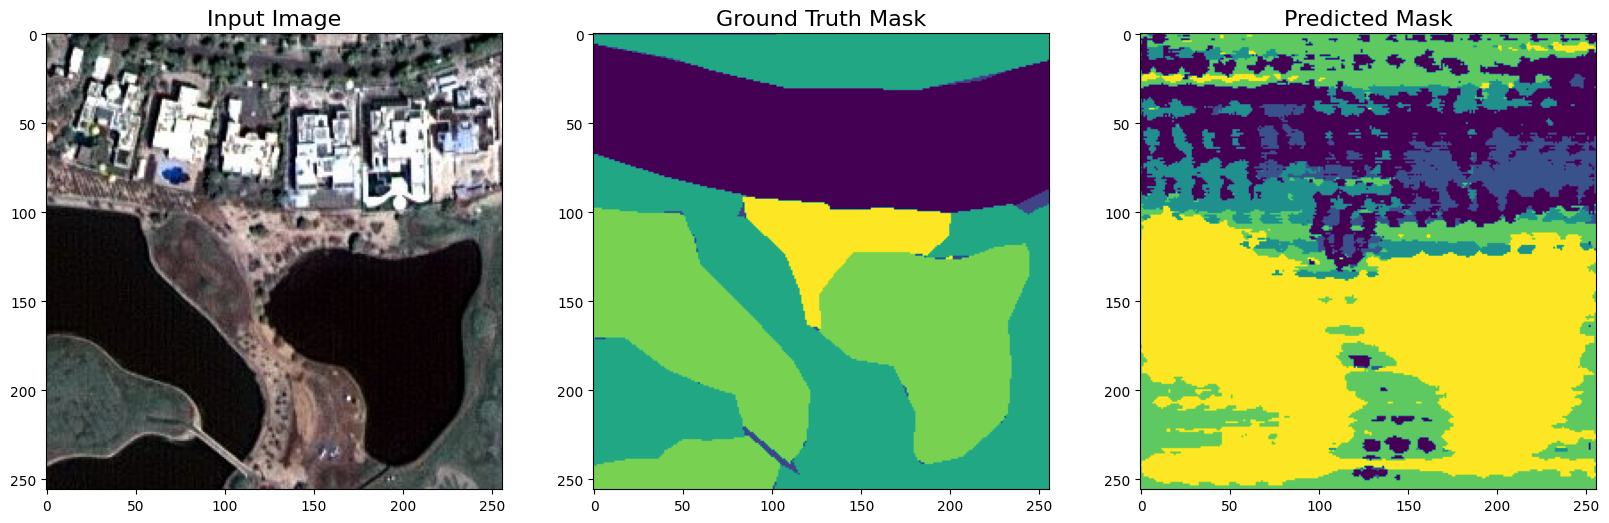

1/1 [==============================] - 0s 94ms/step


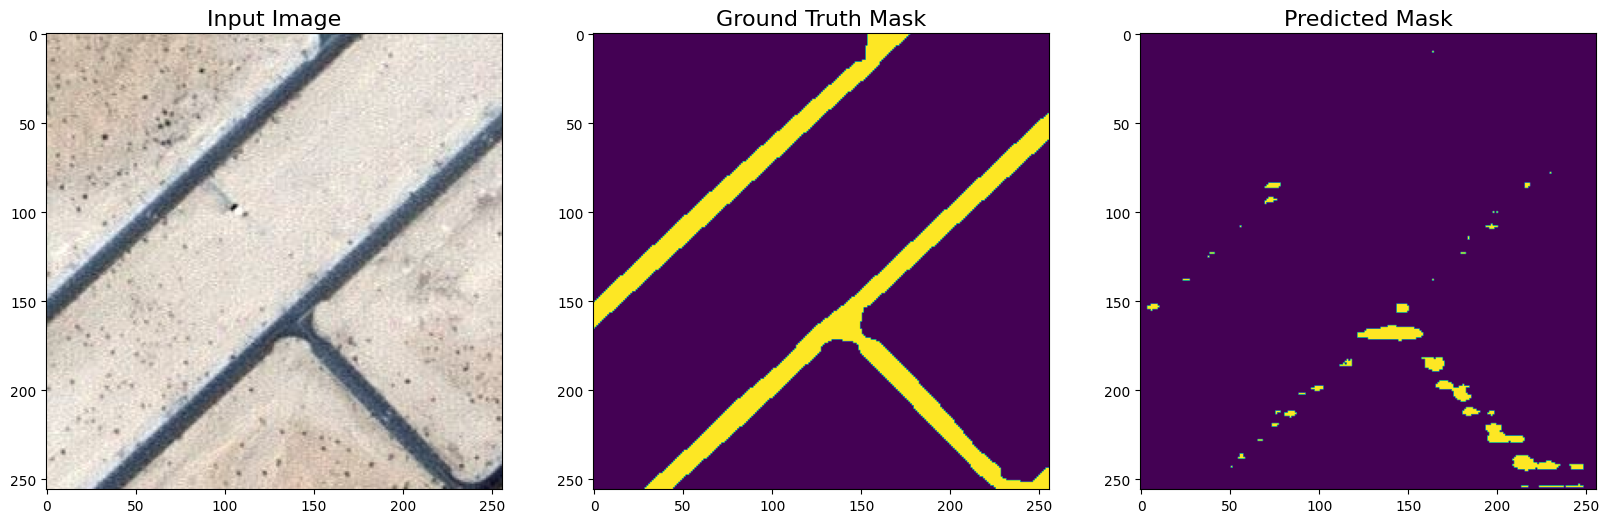

1/1 [==============================] - 0s 96ms/step


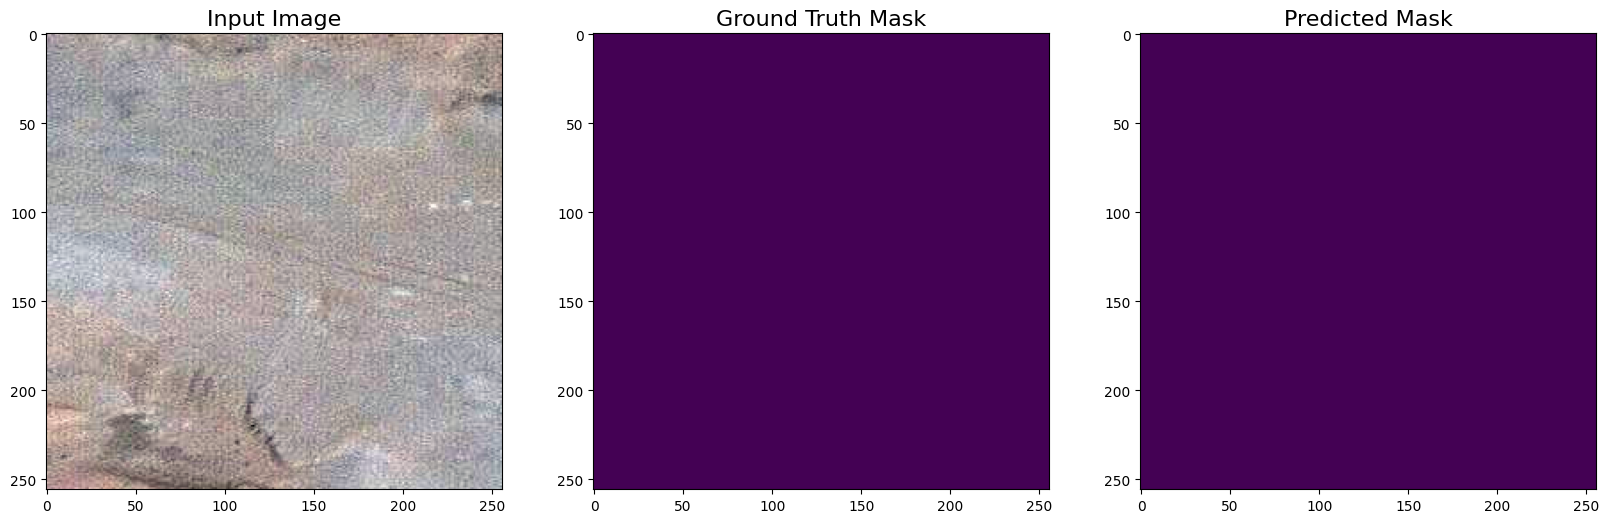

1/1 [==============================] - 0s 109ms/step


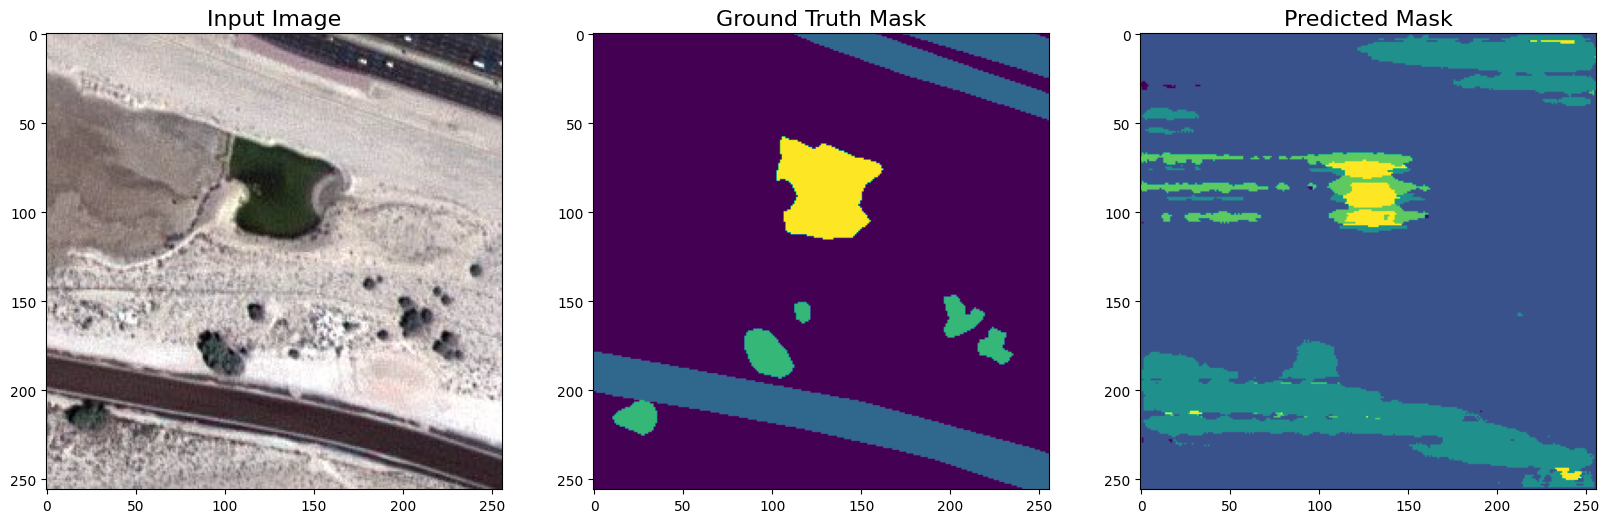

In [21]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(satellite_model_UNETR.predict(np.expand_dims(x_test[i], 0)), axis=3)[0,:,:])

    plt.show()